# Импорт необходимых библиотек

In [1]:
import os
import cv2
import datetime
import numpy as np
from typing import List, Union, Tuple, Dict
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    accuracy_score
)

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
%matplotlib inline
plt.style.use('ggplot')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Описание задачи и критерий оценки результата

ЧТО НУЖНО БУДЕТ СДЕЛАТЬ:

1. Скачать и загрузить датасет.
2. Отрисовать один батч загруженных данных.
3. Выбрать предобученную модель.
4. Обучить многоклассовый классификатор, используя выбранную модель.
5. Визуализировать предсказания модели.
6. Выбрать подходящие метрики качества и посчитать их для обученной модели.
7. Построить матрицу ошибок, определить, каких людей модель путает чаще всего.
8. Попробовать улучшить качество модели, решая задачу в 2 этапа: сначала выполняя детекцию лица, затем выполняя классификацию по кропу лица (для детекции можно использовать любой известный вам подход). 
9. Описать полученные результаты в текстовой ячейке ноутбука.

Основная цель: **accuracy > 0.85** на валидационной выборке.

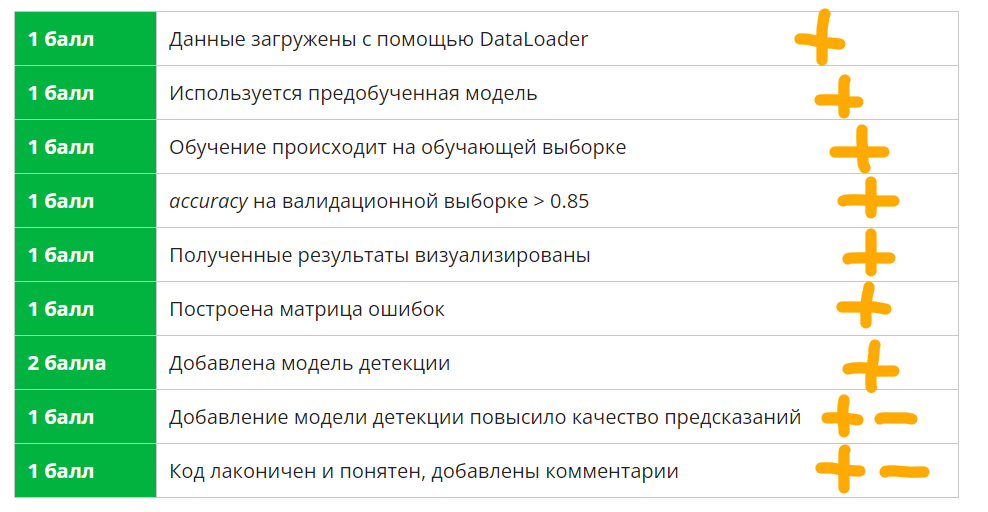

In [119]:
from IPython.display import Image as display_img
display(display_img(filename='criterion.png'))

# Загрузка данных

In [3]:
# создадим отображение int в лейблы, соответствующие знаменитостям в датасете

label_map = dict(enumerate(os.listdir('./data/train')))
print(f'Label maping: {label_map}')

# проверим, все ли размерыности изображений в датасете одинаковы

img_shape_dict = {}

for folder in os.listdir('./data'):
    for foldername in os.listdir(os.path.join('./data', folder)):
        for filename in os.listdir(os.path.join('./data', folder, foldername)):
            f = os.path.join('./data', folder, foldername, filename)
            if os.path.isfile(f):
                img_shape = cv2.imread(f).shape
                try:
                    img_shape_dict[str(img_shape)] += 1
                except:
                    img_shape_dict[str(img_shape)] = 1
                    
print(f'Shape of images: {img_shape_dict}')

Label maping: {0: 'bill_gates', 1: 'elon_musk', 2: 'jeff_bezos', 3: 'mark_zuckerberg', 4: 'steve_jobs'}
Shape of images: {'(70, 70, 3)': 3913, '(285, 229, 3)': 1}


Так как в датасете присутствуют в основном изображения 70х70, то будем проводить resize всех подаваемых в модель изображений к этому размеру.

# Аугментация и деление на train, validation, test

In [4]:
# pipeline трансформаций изображений для аугментированной части датасета
train_transforms_transformed = transforms.Compose(
    [
        transforms.Resize((70, 70)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        # transforms.RandomPerspective(),
        transforms.ToTensor(), # переводим изображение в PyTorch tensor
        # далее будем использовать предобученную модель Resnet, поэтому нормализуем
        # изображения с теми же коэффициентами, что и в ImageNet, на котором обучали Resnet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# pipeline трансформаций изображений для исходной тренировочной части датасета
train_transforms = transforms.Compose(
    [
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# pipeline трансформаций изображений для валидационной части датасета не требуется, т.к. эта часть 
# получена из уже трансформированной части

# pipeline трансформаций изображений для тестовой части датасета
test_transforms = transforms.Compose([
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [5]:
path_to_data = 'data'

training_data_transformed = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms_transformed
)

training_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms
)

# аугментируем исходный датасет сложением с аугментированной частью
training_data_full = training_data_transformed + training_data
# делим полученный датасет на тренировочную и валидационную части
training_data, validation_data = random_split(training_data_full, [int(0.8*len(training_data_full)), 
                                                len(training_data_full) - int(0.8*len(training_data_full))])

# на тестовой выборке будем производить финальную оценку
test_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'valid'),
    transform=test_transforms
)

Далее создаем объекты Dataloader для каждой из частей датасета и выводим количество батчей в каждом из них.

In [6]:
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader  = DataLoader(test_data, batch_size=batch_size)

print(f'Number of batches in train subset: {len(train_dataloader)}')
print(f'Number of batches in validation subset: {len(valid_dataloader)}')
print(f'Number of batches in test subset:  {len(test_dataloader)}')

Number of batches in train subset: 151
Number of batches in validation subset: 38
Number of batches in test subset:  29


Отрисуем один батч изображений:

In [7]:
# функция для отображения изображений
def imshow(img):
    plt.figure(figsize=(16, 4))
    img = img.numpy().transpose((1, 2, 0))
    # проведем операцию, обратную нормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

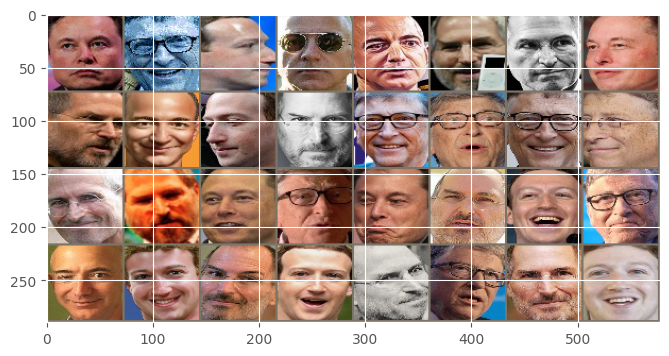

In [8]:
# получим батч из тренировочных данных
inputs, classes = next(iter(train_dataloader))

# и отобразим его
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Построение циклов обучения и валидации

Для начала напишем собственный класс, который будем использовать в дальнейшем для визуализации результатов:

In [9]:
class MyLogWriter:
    """
    Класс для записи числовых значений для последующего построения графиков.
    Данные хранятся в dict.
    """
    def __init__(self):
        self.log_dict = {}

    def add_label(self, labels: List[str]) -> None:
        for label in labels:
            self.log_dict[label] = []
    
    def add_value(self, label: str, value: Union[int, float]) -> None:
        try:
            self.log_dict[label].append(value)
        except:
            self.add_label([label])
            self.log_dict[label].append(value)
    
    def __len__(self) -> int:
        return len(self.log_dict)

    def __call__(self) -> Dict[str, List]:
        return self.log_dict

    def __getitem__(self, label: str) -> List[Union[int, float]]:
        return self.log_dict[label]


class MyPlotter:
    """
    Класс для построения и сохранения графиков.
    На вход принимает словарь.
    """
    def __init__(self, path: str, logs: Dict[str, List[Union[int, float]]]) -> None:
        self.path = path
        self.logs = logs

    def plot_graph(
        self,
        xlabel: str,
        ylabel: str,
        labels: List[str],
        title: str,
        figsize: Tuple[int]=(5, 5),
        save: bool=True
    ) -> None:

        fig, ax = plt.subplots(figsize=figsize, layout="constrained")

        for label in labels:
            ax.plot(self.logs[label], label=label)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(title)
            ax.legend()

        if save:
            # создаем новую папку для сохранения графика
            new_path = os.path.join(self.path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
            os.makedirs(new_path, exist_ok=True)
            # сохраняем в отдельную переменную текущую рабочую директорию
            current_path = os.getcwd()
            # меняем текущую рабочую директорию на созданную папку
            os.chdir(new_path)
            # сохраняем график
            fig.savefig(f'{title}.png')
            # меняем текущую рабочую директорию обратно
            os.chdir(current_path)

Цикл обучения:

In [10]:
# опишем цикл обучения

def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss, train_accuracy = 0, 0
    model.train()
    with tqdm(dataloader, unit='batch') as tepoch:
        for images, labels in tepoch:

            # Определяем описание для tqdm
            tepoch.set_description(f'Epoch {epoch_n}')

            images, labels = images.to(device), labels.to(device)
            # Делаем forward pass
            pred = model(images)
            # вычисляем loss
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # Делаем шаг оптимизатора
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / batch_size

            # Прибавляем loss и accuracy к полным значениям за эпоху
            train_loss += loss.item()
            train_accuracy += correct
            # Выводим в tqdm текущие лосс и точность
            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

    # вычисляем среднее
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    summary_writer.add_value(
        'train_loss',
        train_loss
    )

    summary_writer.add_value(
        'train_accuracy',
        train_accuracy
    )

Цикл валидации:

In [11]:
# опишем цикл для валидации/теста

def valid_loop(dataloader, model, loss_fn, epoch_n,  device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0
    model.eval()
    
    # На этапе валидации нам не нужно вычислять градиенты
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            valid_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= len_of_dataset

    summary_writer.add_value(
        'valid_loss',
        valid_loss
    )

    summary_writer.add_value(
        'valid_accuracy',
        correct
    )

    print(f'Validation Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {valid_loss:>8f} \n')

In [12]:
def make_predictions(dataloader, model, device):
    actual, preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            preds.append(pred)
            actual.append(labels)
    # gc.collect()
    actual, preds = torch.cat(actual), torch.cat(preds)
    return actual.cpu().detach().numpy(), F.softmax(preds, dim=-1).argmax(dim=-1)

# Использование предобученной модели Resnet

## Transfer learning Resnet

### Инициализация модели и процесс обучения

In [13]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model_freeze_conv = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# заморозим веса всей модели
for param in model_freeze_conv.parameters():
    param.requires_grad = False

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model_freeze_conv.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model_freeze_conv.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model_freeze_conv = model_freeze_conv.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

# в качестве оптимизатора указываем SGD с momentum, который использовался в оригинальной модели Resnet
# optimizer = optim.SGD(model_freeze_conv.fc.parameters(), lr=0.001, momentum=0.9)

# попробуем с другим оптимизатором
optimizer = optim.AdamW(model_freeze_conv.fc.parameters(), lr=0.001)

C:\Users\Home\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Запускаем обучение, значения метрик будут записываться в экземпляр класса MyLogWriter:

In [14]:
num_of_epochs = 20

writer = MyLogWriter()

for epoch_n in range(num_of_epochs):
    train_loop(train_dataloader, model_freeze_conv, loss_fn, optimizer, num_of_epochs, device, writer)
    valid_loop(valid_dataloader, model_freeze_conv, loss_fn, num_of_epochs, device, writer)

print("Done!")

  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.780, Avg loss: 0.644367 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.825, Avg loss: 0.519782 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.839, Avg loss: 0.460395 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.854, Avg loss: 0.409501 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.846, Avg loss: 0.439233 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.866, Avg loss: 0.394819 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.854, Avg loss: 0.390260 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.882, Avg loss: 0.354190 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.877, Avg loss: 0.361424 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.874, Avg loss: 0.365452 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.879, Avg loss: 0.345041 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.877, Avg loss: 0.347783 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.884, Avg loss: 0.334602 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.880, Avg loss: 0.342354 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.876, Avg loss: 0.344653 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.888, Avg loss: 0.337658 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.887, Avg loss: 0.322888 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.881, Avg loss: 0.334667 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.875, Avg loss: 0.331910 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.892, Avg loss: 0.319411 

Done!


### Визуализация результатов

Строим и сохраняем графики с результатами метрик:

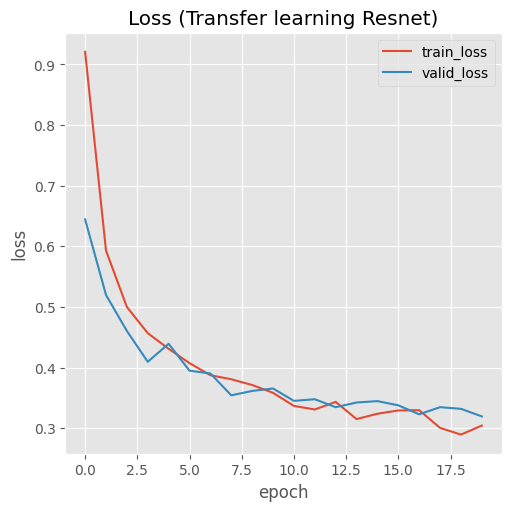

In [15]:
loss_plotter = MyPlotter('./results/loss', writer)

loss_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_loss', 'valid_loss'],
    title='Loss (Transfer learning Resnet)',
    figsize=(5, 5),
    save=True
)

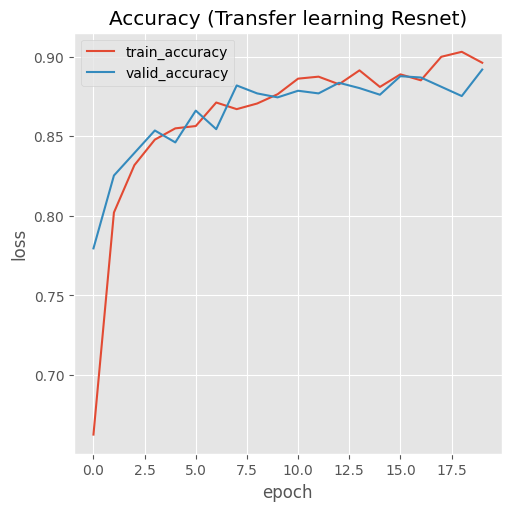

In [16]:
acc_plotter = MyPlotter('./results/accuracy', writer)

acc_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_accuracy', 'valid_accuracy'],
    title='Accuracy (Transfer learning Resnet)',
    figsize=(5, 5),
    save=True
)

### Оценка качества на тестовой выборке

In [17]:
# строим предсказания
actual, preds = make_predictions(test_dataloader, model_freeze_conv, device)
actual, preds = torch.tensor(actual).cpu(), torch.tensor(preds).cpu()

C:\Users\Home\AppData\Local\Temp\ipykernel_2368\3901526382.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual, preds = torch.tensor(actual).cpu(), torch.tensor(preds).cpu()


Accuracy_score: 0.8877995642701525

Classification report: 
                 precision    recall  f1-score   support

     bill_gates       0.97      0.94      0.95       223
      elon_musk       0.86      0.83      0.85       194
     jeff_bezos       0.91      0.83      0.87       214
mark_zuckerberg       0.89      0.91      0.90       221
     steve_jobs       0.68      0.98      0.81        66

       accuracy                           0.89       918
      macro avg       0.86      0.90      0.88       918
   weighted avg       0.90      0.89      0.89       918



[Text(0.5, 58.5815972222222, 'PREDICTED labels'),
 Text(95.58159722222221, 0.5, 'TRUE labels'),
 Text(0.5, 1.0, 'Матрица ошибок')]

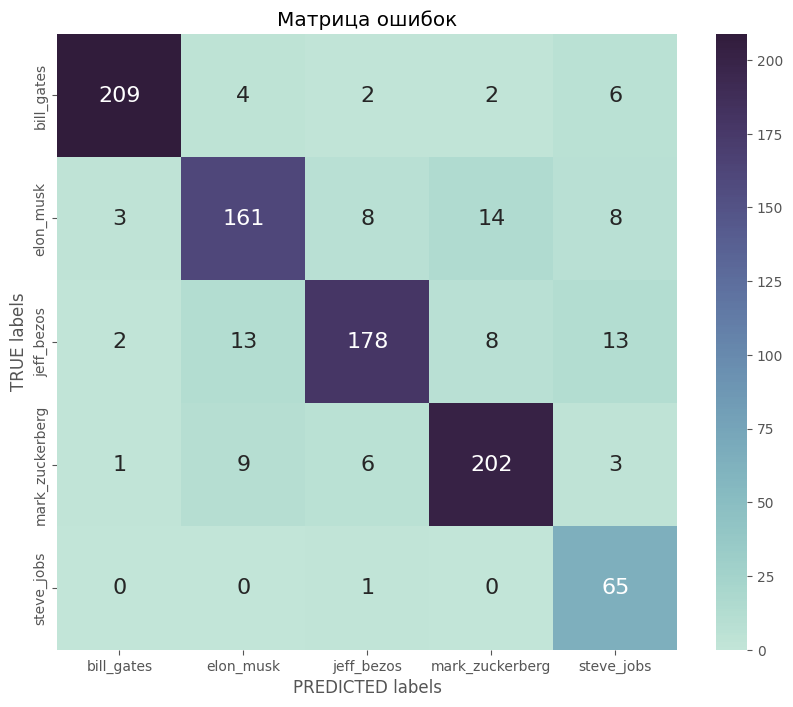

In [18]:
print(f'Accuracy_score: {accuracy_score(actual, preds)}')

print('\nClassification report: ')
print(classification_report(actual, preds, target_names=label_map.values()))

# Визуализируем матрицу ошибок в виде тепловой карты seaborn
plt.figure(figsize=(10,8))
sns.heatmap(
    confusion_matrix(actual, preds),
    xticklabels=label_map.values(),
    yticklabels=label_map.values(),
    fmt='d', annot=True, annot_kws={"size": 16},
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
).set(xlabel='PREDICTED labels', ylabel='TRUE labels', title='Матрица ошибок')

ВЫВОД: 

## Fine tuning Resnet

### Инициализация модели и процесс обучения

In [19]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model = model.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.fc.parameters(), lr=0.001)

C:\Users\Home\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Запускаем обучение, значения метрик будут записываться в экземпляр класса MyLogWriter:

In [21]:
num_of_epochs = 20

writer = MyLogWriter()

for epoch_n in range(num_of_epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, num_of_epochs, device, writer)
    valid_loop(valid_dataloader, model, loss_fn, num_of_epochs, device, writer)

print("Done!")

  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.824, Avg loss: 0.495447 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.829, Avg loss: 0.480935 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.848, Avg loss: 0.446308 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.859, Avg loss: 0.401876 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.864, Avg loss: 0.397067 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.880, Avg loss: 0.374341 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.864, Avg loss: 0.382610 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.884, Avg loss: 0.335866 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.868, Avg loss: 0.368400 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.879, Avg loss: 0.346574 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.871, Avg loss: 0.357786 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.889, Avg loss: 0.325558 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.887, Avg loss: 0.330469 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.890, Avg loss: 0.328273 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.884, Avg loss: 0.350500 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.875, Avg loss: 0.356980 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.900, Avg loss: 0.318094 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.884, Avg loss: 0.335467 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.868, Avg loss: 0.362776 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.881, Avg loss: 0.331792 

Done!


### Визуализация результатов

Строим и сохраняем графики с результатами метрик:

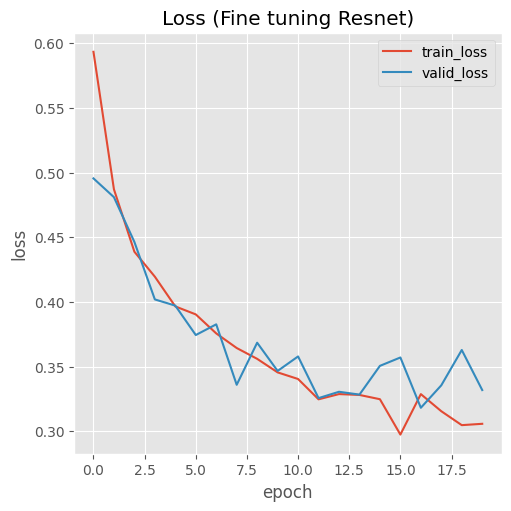

In [22]:
loss_plotter = MyPlotter('./results/loss', writer)

loss_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_loss', 'valid_loss'],
    title='Loss (Fine tuning Resnet)',
    figsize=(5, 5),
    save=True
)

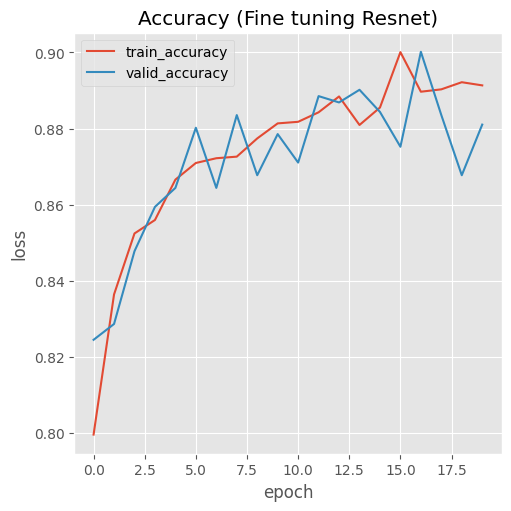

In [23]:
acc_plotter = MyPlotter('./results/accuracy', writer)

acc_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_accuracy', 'valid_accuracy'],
    title='Accuracy (Fine tuning Resnet)',
    figsize=(5, 5),
    save=True
)

### Оценка качества на тестовой выборке

In [24]:
actual, preds = make_predictions(test_dataloader, model, device)
actual, preds = torch.tensor(actual).cpu(), torch.tensor(preds).cpu()

C:\Users\Home\AppData\Local\Temp\ipykernel_2368\4256865331.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual, preds = torch.tensor(actual).cpu(), torch.tensor(preds).cpu()


Accuracy_score: 0.8812636165577342

Classification report: 
                 precision    recall  f1-score   support

     bill_gates       0.98      0.90      0.94       223
      elon_musk       0.83      0.85      0.84       194
     jeff_bezos       0.91      0.85      0.87       214
mark_zuckerberg       0.84      0.92      0.88       221
     steve_jobs       0.83      0.88      0.85        66

       accuracy                           0.88       918
      macro avg       0.88      0.88      0.88       918
   weighted avg       0.89      0.88      0.88       918



[Text(0.5, 58.5815972222222, 'PREDICTED labels'),
 Text(95.58159722222221, 0.5, 'TRUE labels'),
 Text(0.5, 1.0, 'Матрица ошибок')]

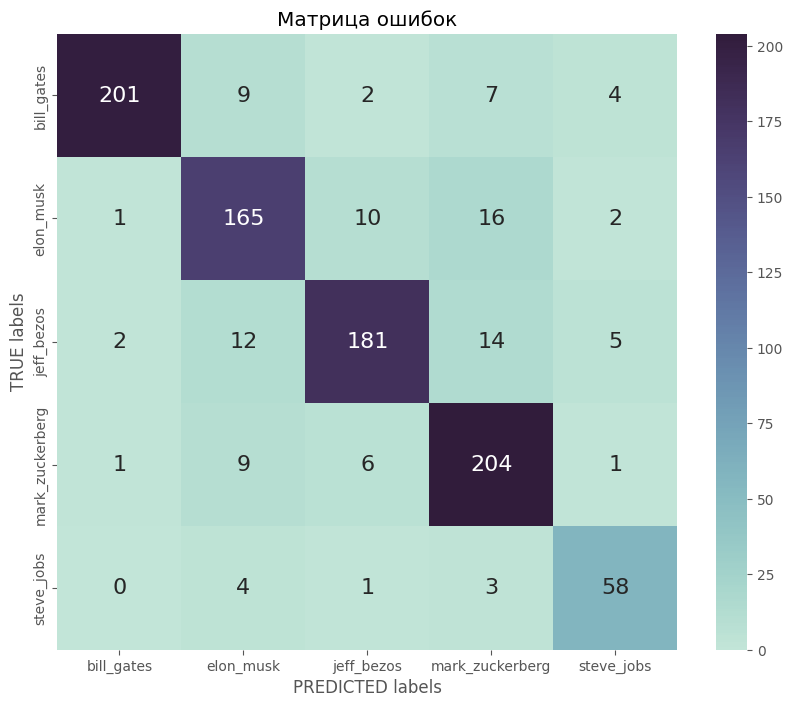

In [25]:
print(f'Accuracy_score: {accuracy_score(actual, preds)}')

print('\nClassification report: ')
print(classification_report(actual, preds, target_names=label_map.values()))

# Визуализируем матрицу ошибок в виде тепловой карты seaborn
plt.figure(figsize=(10,8))
sns.heatmap(
    confusion_matrix(actual, preds),
    xticklabels=label_map.values(),
    yticklabels=label_map.values(),
    fmt='d', annot=True, annot_kws={"size": 16},
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
).set(xlabel='PREDICTED labels', ylabel='TRUE labels', title='Матрица ошибок')

ВЫВОД: модель в этот раз показала сопоставимое значение accuracy, однако класс 'steve_jobs' значительно лучше классифицировался. В целом результаты предсказаний по классам более сбалансированны.

# Face detection + transfer learning Resnet

## Загрузка предобученной модели детекции

Скачиваем обученную модель детекции лиц:

In [26]:
!mkdir face_detector
# !wget "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel" -q -O ./face_detector/model.caffemodel
# !wget "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt" -q -O ./face_detector/model.prototxt

!curl -so ./face_detector/model.caffemodel "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel" 
!curl -so ./face_detector/model.prototxt "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"

Подпапка или файл face_detector уже существует.


In [27]:
PATH_TO_WEIGHTS = './face_detector/model.caffemodel'
PATH_TO_PROTOTXT = './face_detector/model.prototxt'

net = cv2.dnn.readNetFromCaffe(PATH_TO_PROTOTXT, PATH_TO_WEIGHTS)

Детекция будет включена в виде лямбда-функции для torchvision.transforms.Compose, поэтому обернем в отдельную функцию обработку входящего изображения для инференса предварительно обученной модели детекции:

In [28]:
def detect_face(img):
    # изображение из PyTorch Dataloader поступает в виде объекта PIL.Image.Image,
    # поэтому для удобства конвертируем в numpy.ndarray
    img = np.asarray(img)
    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(
                img,
                1.0,
                (300, 300), (104.0, 177.0, 123.0)
            )

    net.setInput(blob)
    detections = net.forward()
    img_copy = img.copy()

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.3:
            box = (detections[0, 0, i, 3:7] * np.array([w, h, w, h])).astype(np.int32)
            # обрезаем изображение по границам детектированного лица
            crop = img_copy[box[1]:box[3], box[0]:box[2]]
            # прервем цикл, так как в нашей задаче подразумевается наличие на входном
            # изображении одного лица, а модель детекции способна детектировать
            # несколько лиц с одного изображения
            break
    try:
        return Image.fromarray(crop) # переводим обратно в формат PIL.Image.Image
    except:
        return Image.fromarray(img_copy) # если модель не детектировала ни одного лица

## Аугментация и деление на train, validation, test

In [29]:
# весь процесс трансформации и аугментации остался прежним за исключением добавления
# lambda трансформации
train_transforms_transformed = transforms.Compose(
    [
        transforms.Lambda(detect_face),
        transforms.Resize((70, 70)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        # transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

train_transforms = transforms.Compose(
    [
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Lambda(detect_face),
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [30]:
path_to_data = 'data'

training_data_transformed = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms_transformed
)

training_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms
)

training_data_full = training_data_transformed + training_data

training_data, validation_data = random_split(training_data_full, [int(0.8*len(training_data_full)), 
                                                len(training_data_full) - int(0.8*len(training_data_full))])

test_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'valid'),
    transform=test_transforms
)

In [31]:
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader  = DataLoader(test_data, batch_size=batch_size)

print(f'Number of batches in train subset: {len(train_dataloader)}')
print(f'Number of batches in validation subset: {len(valid_dataloader)}')
print(f'Number of batches in test subset:  {len(test_dataloader)}')

Number of batches in train subset: 151
Number of batches in validation subset: 38
Number of batches in test subset:  29


In [32]:
# функция для отображения изображений
def imshow(img):
    plt.figure(figsize=(16, 4))
    img = img.numpy().transpose((1, 2, 0))
    # проведем операцию, обратную нормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

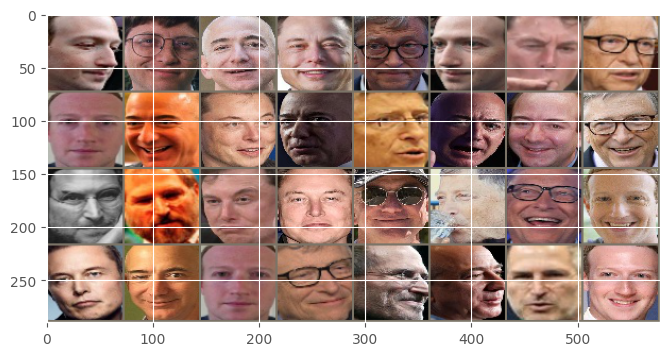

In [33]:
# получим батч из тренировочнх данных
inputs, classes = next(iter(train_dataloader))

# и отобразим его
out = torchvision.utils.make_grid(inputs)
imshow(out)

## Инициализация модели и процесс обучения

In [34]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model_freeze_conv_det = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# заморозим веса всей модели
for param in model_freeze_conv_det.parameters():
    param.requires_grad = False

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model_freeze_conv_det.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model_freeze_conv_det.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model_freeze_conv_det = model_freeze_conv_det.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model_freeze_conv_det.fc.parameters(), lr=0.001)

C:\Users\Home\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
num_of_epochs = 20

# writer = SummaryWriter('runs/resnet_ft') # при использовании Tensorboard
writer = MyLogWriter()

for epoch_n in range(num_of_epochs):
    train_loop(train_dataloader, model_freeze_conv_det, loss_fn, optimizer, num_of_epochs, device, writer)
    valid_loop(valid_dataloader, model_freeze_conv_det, loss_fn, num_of_epochs, device, writer)

# writer.close()
print("Done!")

  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.757, Avg loss: 0.689310 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.780, Avg loss: 0.592770 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.802, Avg loss: 0.535204 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.824, Avg loss: 0.496788 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.810, Avg loss: 0.512299 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.829, Avg loss: 0.472123 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.827, Avg loss: 0.467183 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.816, Avg loss: 0.481730 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.827, Avg loss: 0.449751 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.839, Avg loss: 0.442507 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.852, Avg loss: 0.420814 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.837, Avg loss: 0.430944 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.848, Avg loss: 0.419357 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.839, Avg loss: 0.446099 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.853, Avg loss: 0.415287 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.848, Avg loss: 0.413549 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.846, Avg loss: 0.402252 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.857, Avg loss: 0.409539 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.857, Avg loss: 0.422736 



  0%|          | 0/151 [00:00<?, ?batch/s]

Validation Metrics: 
 Accuracy: 0.859, Avg loss: 0.407643 

Done!


## Визуализация результатов

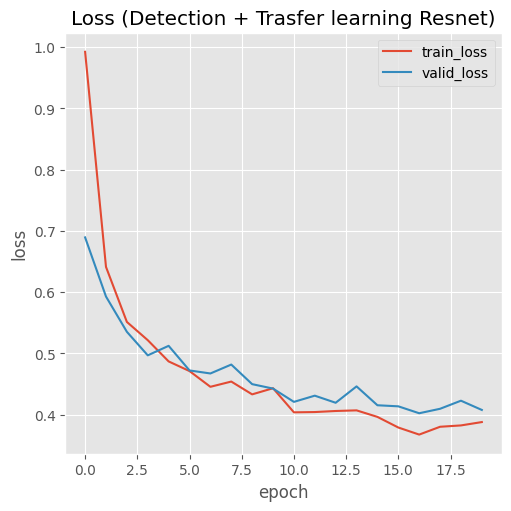

In [36]:
loss_plotter = MyPlotter('./results/loss', writer)

loss_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_loss', 'valid_loss'],
    title='Loss (Detection + Trasfer learning Resnet)',
    figsize=(5, 5),
    save=True
)

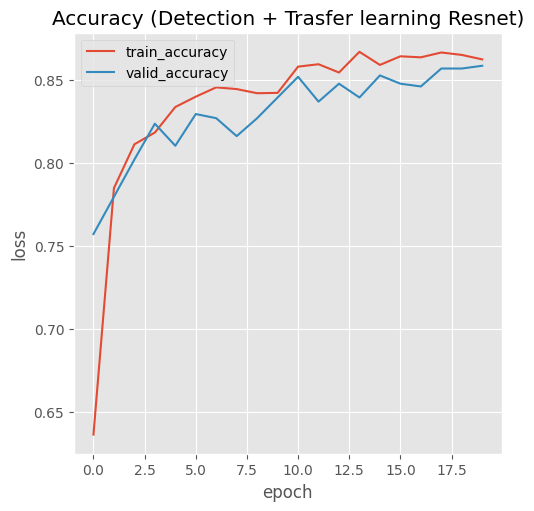

In [37]:
acc_plotter = MyPlotter('./results/accuracy', writer)

acc_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_accuracy', 'valid_accuracy'],
    title='Accuracy (Detection + Trasfer learning Resnet)',
    figsize=(5, 5),
    save=True
)

## Оценка качества на тестовой выборке

In [38]:
actual, preds = make_predictions(test_dataloader, model_freeze_conv_det, device)
actual, preds = torch.tensor(actual).cpu(), torch.tensor(preds).cpu()

C:\Users\Home\AppData\Local\Temp\ipykernel_2368\2236961866.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual, preds = torch.tensor(actual).cpu(), torch.tensor(preds).cpu()


Accuracy_score: 0.8322440087145969

Classification report: 
                 precision    recall  f1-score   support

     bill_gates       0.94      0.95      0.94       223
      elon_musk       0.86      0.73      0.79       194
     jeff_bezos       0.75      0.84      0.79       214
mark_zuckerberg       0.90      0.77      0.83       221
     steve_jobs       0.63      0.94      0.75        66

       accuracy                           0.83       918
      macro avg       0.81      0.84      0.82       918
   weighted avg       0.84      0.83      0.83       918



[Text(0.5, 58.5815972222222, 'PREDICTED labels'),
 Text(95.58159722222221, 0.5, 'TRUE labels'),
 Text(0.5, 1.0, 'Матрица ошибок')]

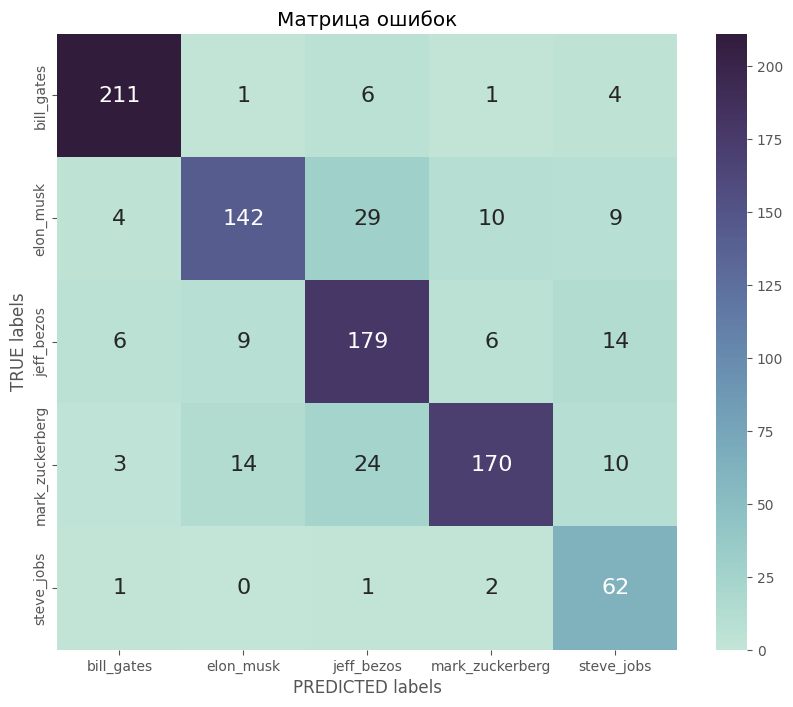

In [40]:
print(f'Accuracy_score: {accuracy_score(actual, preds)}')

print('\nClassification report: ')
print(classification_report(actual, preds, target_names=label_map.values()))

# Визуализируем матрицу ошибок в виде тепловой карты seaborn
plt.figure(figsize=(10,8))
sns.heatmap(
    confusion_matrix(actual, preds),
    xticklabels=label_map.values(),
    yticklabels=label_map.values(),
    fmt='d', annot=True, annot_kws={"size": 16},
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
).set(xlabel='PREDICTED labels', ylabel='TRUE labels', title='Матрица ошибок')

ВЫВОДЫ: результаты ухудшились, что довольно очевидно, т.к. исходный набор фактически уже содержит только обрезанные лица. Таким образом, модель детекции пыталась детектировать лица на изображениях лиц. То есть вероятные ошибки модели детекции наложились на ошибки классификатора, что в итоге и привело к снижению качества. Однако данная модель в теории должна показать себя лучше на внешних данных, где картинка содержит не только лицо.

# Проверка на внешних данных

In [103]:
# функция предсказания лейбла по трансформированной картинке
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return label_map[int(preds[0])]

In [104]:
from pathlib import Path

def predict_external_image(image_name, model):
    image = Image.open(Path('./external_data/' + image_name))
    example_image = test_transforms(image)
    imshow(example_image)
    print("The image resembles", predict_image(example_image, model) + ".")

Сравнивать будем на предварительно загруженных изображениях из интернета. Изображения приближены к реальным условиям, т.е. на них изображена знаменитось на каких-либо мероприятиях, поэтому изображения содержат не только лица.

Сравнивать будем модель "Fine tuning Resnet" и "Face detection + transfer learning Resnet".

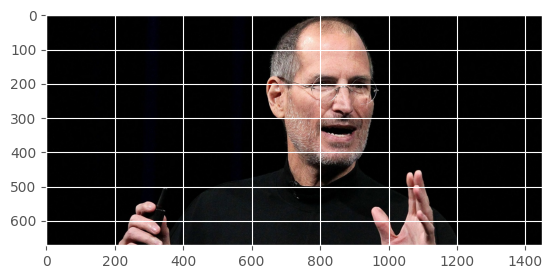

In [105]:
# для начала выведем тестовое изображение Стива Джобса
img_ = cv2.imread('./external_data/s_j3.jpg')
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB )
plt.imshow(img_)

The image resembles steve_jobs.


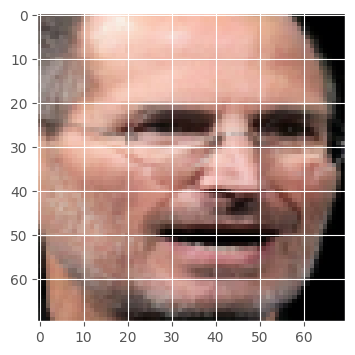

In [106]:
# результат модели "Face detection + transfer learning Resnet"
predict_external_image('s_j3.jpg', model_freeze_conv_det)

In [108]:
# выше в коде test_transforms содержит модель детекции, поэтому создадим новую переменную
# с теми же трансформациями, что были в модели "Fine tuning Resnet"
test_transforms_ = transforms.Compose(
    [
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# ну и соответственно определим новую функцию с этой трансформацией
def predict_external_image_(image_name, model):
    image = Image.open(Path('./external_data/' + image_name))
    example_image = test_transforms_(image)
    imshow(example_image)
    print("The image resembles", predict_image(example_image, model) + ".")

The image resembles jeff_bezos.


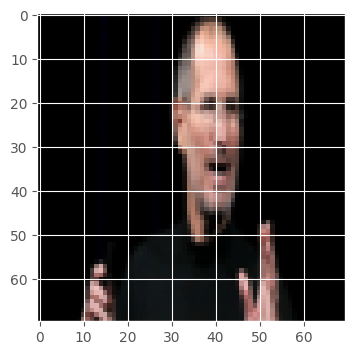

In [110]:
# результат модели "Fine tuning Resnet"
predict_external_image_('s_j3.jpg', model)

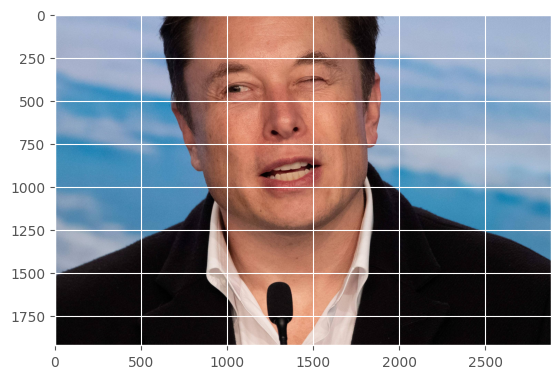

In [111]:
# попробуем следующее изображение, на этот раз Илона Маска
img_ = cv2.imread('./external_data/i_m3.jpg')
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB )
plt.imshow(img_)

The image resembles elon_musk.


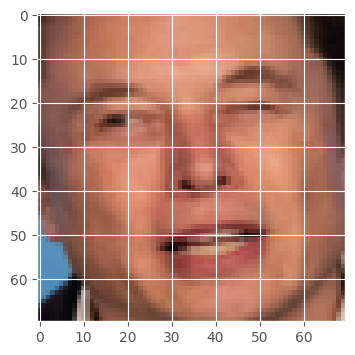

In [112]:
# результат модели "Face detection + transfer learning Resnet"
predict_external_image('i_m3.jpg', model_freeze_conv_det)

The image resembles mark_zuckerberg.


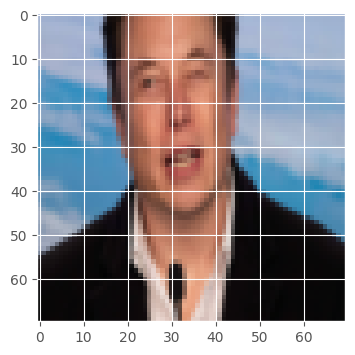

In [113]:
# результат модели "Fine tuning Resnet"
predict_external_image_('i_m3.jpg', model)

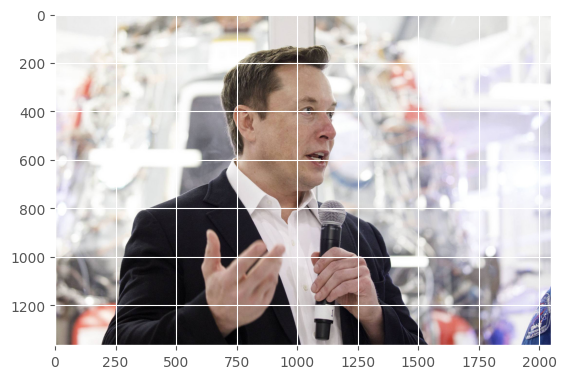

In [114]:
# ну и напоследок еще одно изображение Илона Маска
img_ = cv2.imread('./external_data/i_m.jpeg')
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB )
plt.imshow(img_)

The image resembles elon_musk.


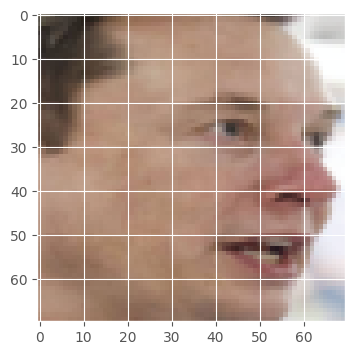

In [115]:
# результат модели "Face detection + transfer learning Resnet"
predict_external_image('i_m.jpeg', model_freeze_conv_det)

The image resembles steve_jobs.


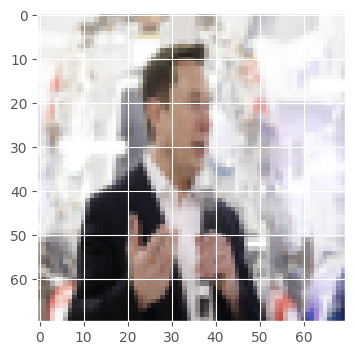

In [116]:
# результат модели "Fine tuning Resnet"
predict_external_image_('i_m.jpeg', model)

Вывод: результаты работы модели классификации с предварительной детекцией лиц на изображениях, приближенных к реальным сценам, оказались значительно лучше. Модель без детекции лиц для этих целей совершенно не годится. Модель с детекцией лиц довольно неплохо детектирует, а затем классифицирует лица.